# 09_PyTorch Model Deployment


What is model deployment?

Machine learning model deployment is an act of making your machine learning model(s) available to someone or something else.


In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 13.43 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting Data

The dataset we're going to use for deploying a FoodVision Mini model is...

Pizza, steak, sushi 20% dataset (pizza, steak, sushi classes from Food101 dataset random 20% of samples.)

In [3]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [4]:
# Setup training dir and test dir
train_dir = data_20_percent_path / "train"
train_dir

test_dir = data_20_percent_path / "test"

## 2. FoodVision Mini model deployment experiment outline

### 3 questions:
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast.

1. Performs well: 95%+ accuracy
2. Fast: as close to real time (or faster) as close to real time as possible (30FPS+ or 30 ms Latency)
  * Latency  = time for prediction to take place

To try and achieve these goals we're going to build two model experiments:
1. EffNetB2 feature extractor (just like in 07. PyTorch Experiment Tracking)
2. ViT feature extractor (just like in 08. PyTorch paper replicating)


## 3. Creating an EffNetB2 feature extractor

Feature extractor = a term for a transfer learning model that has its base layers frozen and output layers (or head layers) customized to a certain problem.

EffNetB2 pretrained model in PyTorch.

In [5]:
import torchvision

# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # Best weights available

# 2. Get effnetb2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights = effnetb2_weights)

# 4. Freeze base layers (This will stop all layers from training)
for param in effnetb2.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 165MB/s]


In [6]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [7]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
# Set seeds
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features = 1408,
              out_features = 3))

### 3.1 Creating a function to make an EffNetB2 feature extractor

In [9]:
import torchvision
def create_effnetb2_model(num_classes :int =3,
                          seed : int = 42):
  """ Create an return a pretraiend model weights and transforms """
  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model

  # 1. Setup pretrained model weights
  model_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

  # 2. Get effnetb2 transforms
  effnetb2_transforms = model_weights.transforms()

  # 3. Create model instance
  model = torchvision.models.efficientnet_b2(weights = model_weights)

  # 4. Freeze all the layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change the classifier head
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features = 1408,
                out_features = num_classes))

  return model, effnetb2_transforms

In [10]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes = 3,
                                                      seed = 42)
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [11]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.2 Creating DataLoaders for EffNetB2

In [12]:
# Setup Dataloaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = effnetb2_transforms,
    batch_size = 32)

In [13]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), len(class_names)

(15, 5, 3)

### 3.3 Training EffNetB2 Feature extractor

In [14]:
from going_modular.going_modular import engine

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params = effnetb2.parameters(),
                             lr = 1e-3)

# Training function (engine.py)
set_seeds()
effnetb2_results = engine.train(model = effnetb2,
                                train_dataloader = train_dataloader_effnetb2,
                                test_dataloader = test_dataloader_effnetb2,
                                epochs = 10,
                                optimizer = optimizer,
                                loss_fn = loss_fn,
                                device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


### 3.4 Inspecting effnetb2 loss curves

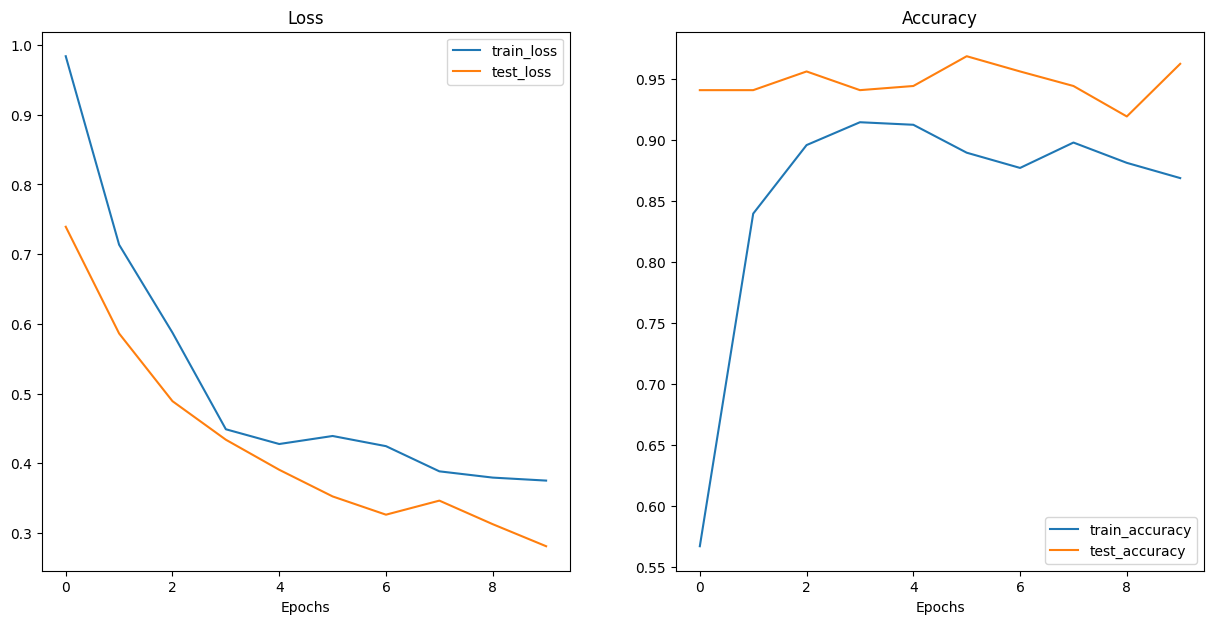

In [15]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 Feature Extractor

In [16]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model = effnetb2,
                 target_dir = "models",
                 model_name = "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Inspecting the size of EffNetV2 feature extractor

WHy would it be important to consider the size of a saved model?

If we're deploying our model to be used on a mobile app/website, there may be limited compute resources.

So if our model is too large we may not be able to store and run it on our target device.

In [17]:
from pathlib import Path

# Get the model size in bytes and convert it to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / 1024 / 1024
print(f"Pretrained effnetb2 model size : {round(pretrained_effnetb2_model_size, 2)} MB")

Pretrained effnetb2 model size : 29.86 MB


### 3.7 Collect EffNetB2 feature extractor stats

In [18]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [19]:
# Create a dictionary with effnetb2 dictionary
effnetb2_stats = {"test_loss":effnetb2_results["test_loss"][-1],
                  "test_acc":effnetb2_results["test_acc"][-1],
                  "number_of_parameters":effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.28108686208724976,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166}

## 4. Creating a ViT feature Extractor

we're up to our second modelling experiment, repeating the steps for EffNetB2 but this time with a ViT feature extractor.

In [ ]:
import torchvision

# 1. Setup pretrained ViT model's weights
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Get vit transforms
vit_transforms = vit_weights.transforms()

# 3. Create an instance of vit model
vit = torchvision.models.vit_b_16(weights = vit_weights)

# 4. Freeze the base layers
for param in vit.parameters():
    param.requires_grad = False

### 4.1  Create a function to make a vit feature extractor



In [ ]:
def create_vit_model(num_classes, seed = 42):
  # 1. Setup pretrained ViT model's weights
  vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

  # 2. Get vit transforms
  vit_transforms = vit_weights.transforms()

  # 3. Create an instance of vit model
  vit = torchvision.models.vit_b_16(weights = vit_weights)

  # 4. Freeze the base layers
  for param in vit.parameters():
      param.requires_grad = False

  # 5. Change the classifier head
  torch.manual_seed(seed)
  vit.heads = nn.Sequential(nn.Linear(in_features = 768,
                                      out_features = num_classes))

  return vit, vit_transforms

In [ ]:
# Print vit model summary (uncomment for full output)
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

In [ ]:
# Create an instance of the vit model
vit, vit_transforms = create_vit_model(num_classes = 3,
                                       seed = 42)
vit_transforms

### 4.2 Creating dataloaders for ViT_B16 model

In [ ]:
from going_modular.going_modular import data_setup

# Setup training and testing dataloaders
train_dataloader_vit, test_dataloader_vit, classes = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = vit_transforms,
    batch_size = 32)
len(train_dataloader_vit), len(test_dataloader_vit), classes

### 4.3 Training a ViT feature extractor

In [ ]:
from going_modular.going_modular import engine

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup optimizer
optimizer = torch.optim.Adam(params = vit.parameters(),
                             lr = 0.001)

# Set seed
set_seeds()
# vit_results = engine.train(model = vit,
#                            train_dataloader = train_dataloader_vit,
#                            test_dataloader = test_dataloader_vit,
#                            optimizer = optimizer,
#                            loss_fn = loss_fn,
#                            epochs = 10,
#                            device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### 4.4 Inspecting ViT loss curves

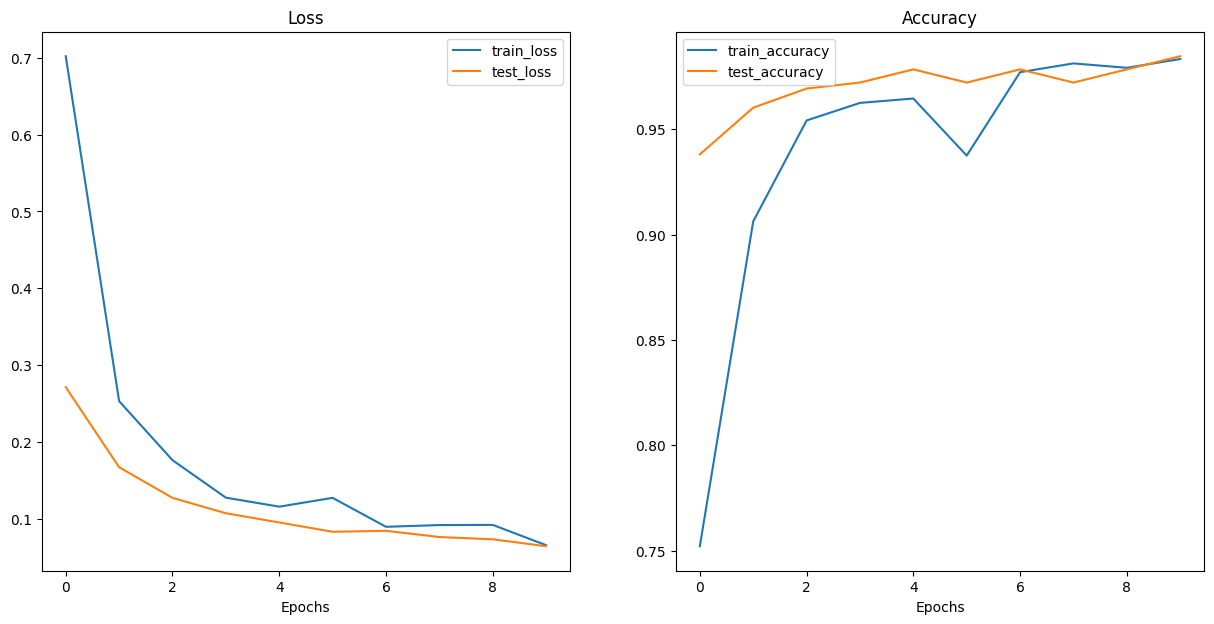

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

### 4.5 Saving ViT Feature Extractor


In [ ]:
from going_modular.going_modular import utils

utils.save_model(model = vit,
                 target_dir = "models",
                 model_name = "09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.6 Inspecting the size of ViT Feature Extractor

In [ ]:
from pathlib import Path

# Get the stats of model size
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / 1024**2
print(f"Pretrained vit model size : {round(pretrained_vit_model_size, 2)} MB")

Pretrained vit model size : 327.37 MB


### 4.7 Collect ViT Feature Extractor stats

In [ ]:
# Count number of parameters in EffNetB2
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [ ]:
# Create a dictionary with effnetb2 dictionary
vit_stats = {"test_loss":vit_results["test_loss"][-1],
             "test_acc":vit_results["test_acc"][-1],
             "number_of_parameters":vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37096977233887}

## 5 Making predictions with our trained models and timing them

Our goal:
1. Performs well (95+ test accuracy)
2. Fast (30+ FPS)

To test criteria two:
1. Loop through test images to time how long each model takes to make a prediction on the image.

Let's work towards make a function called `pred_and_store()` to do so.

First we'll need a list of test image paths.

In [ ]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1618659.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2901001.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/833711.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2398925.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/296426.jpg')]

### 5.1 Creating a function ot make predictions across the test dataset

1. Creating a function that takes a list of paths and a trained PyTorch and a series of transforms a list of target class names and a target device.
2. Create an emtpy list (can return a full list of all predictions later).
3. Loop through the target input paths (the rest of the steps will take inside the loop).
4. Create an empty dictionary for each sample (prediction statistics will go in here).
5. Get the sample path and ground truth class from the filepath.
6. Start the prediction timer.
7. Open the image using `PIL.image.open(path)`.
8. Transform the image to be usable with a given model.
9. Prepare the model for inferene by sending it to the target device and turning on `eval()` mode
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class
11. Add the pred prob + pred class to empty dictionary from step 4.
12. End the prediction time started in step 6 and add the time to tthe prediction dictionary.
13. See if the predicted class matches the ground truth class.
14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
15. Return the list of predicton dictionaries.

In [ ]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Creating a function that takes a list of paths and a trained PyTorch and a series of transforms a list of target class names and a target device.
def pred_and_store(paths: List[pathlib.Path],
                   model : torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names : List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  # 2. Create an empty list (can return a full list of all predictions later)
  pred_list = []

  # 3. Loop through the target input paths (teh rest of the steps will take place inside the loop)
  for path in tqdm(paths):

    # 4. Create an empty dictionary for each sample (prediction statistics will go in here).
    pred_dict = {}

    # 5. Get the sample path and ground truth class from the filepath.
    pred_dict["image_path"] = path
    class_name = path.parent.stem # Parent directory with stem being the final bit
    pred_dict["class_name"] = class_name

    # 6. Start the prediction timer
    start_time = timer()

    # 7. Open the image using PIL.image.open(path).
    img = Image.open(path)

    # 8. Transform the image to be usable with a given model.
    transformed_image = transform(img).unsqueeze(0).to(device) # also add teh batch dimension and send to right device

    # 9. Prepare the model for inferene by sending it to the target device and turning on eval() mode
    model = model.to(device)
    model.eval()

    # 10. Turn on torch.inference_mode() and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim = 1) # Turn logit into prediction probs
      pred_label = torch.argmax(pred_prob, dim = 1) # Turn prediction probability into pred label
      pred_class = class_names[pred_label.cpu()] # Hardcode prediction class to be on the cpu since python variables live on cpu.

      # 11. Add the pred prob + pred class to empty dictionary from step 4.
      pred_dict['pred_prob'] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4) # Find the vaue of max prediction prob
      pred_dict['pred_class'] = pred_class

      # 12.End the prediction time started in step 6 and add the time to tthe prediction dictionary.
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time - start_time, 4)

      # 13. See if the predicted class matches the ground truth class.
      pred_dict["correct"] = class_name == pred_class

      # 14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
      pred_list.append(pred_dict)

  # 15. Return the list of predicton dictionaries.
  return pred_list

### 5.2 Making and timing predictions with EffNetB2

Let's test our `pred_and_store()` function.

Two things to note:
1. Device - We're going to hardcode our predictions to happen on CPU (because you won't always be sure of having a GPU when you deploy your model).
2. Transforms - we want to make sure each of the models are predicting on images that have been prepared with the appropriate transforms (e.g. EffNetB2 with `effnetb2_transforms`)


In [ ]:
# Make prediction test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                          model = effnetb2,
                                          transform = effnetb2_transforms,
                                          class_names = class_names,
                                          device = 'cpu') # Hardcode predictions to happen on cpu

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1618659.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.5099,
  'pred_class': 'sushi',
  'time_for_pred': 0.3441,
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2901001.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.7434,
  'pred_class': 'pizza',
  'time_for_pred': 0.1222,
  'correct': True}]

In [ ]:
# Turn_the_test pred dict into dataframes
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.5099,sushi,0.3441,False
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.7434,pizza,0.1222,True
2,data/pizza_steak_sushi_20_percent/test/pizza/8...,pizza,0.6413,pizza,0.1031,True
3,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.8828,pizza,0.1056,True
4,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.8495,pizza,0.1015,True


In [ ]:
# check the number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

correct
True     144
False      6
Name: count, dtype: int64

In [ ]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction : {effnetb2_average_time_per_pred}")

EffNetB2 average time per prediction : 0.1308


> **NOTE:** Prediction times will vary (much like training times) depending on the hardware you're using... so generally the faster your compute (e.g. CPU or GPU), the faster the predictions will happen.

In [ ]:
# Add time per pred to EffNetB2 stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28108686208724976,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166,
 'time_per_pred_cpu': 0.1308}

### 5.3 Making and timing predictions with ViT

Let's test our `pred_and_store()` function.

Two things to note:
1. Device - We're going to hardcode our predictions to happen on CPU (because you won't always be sure of having a GPU when you deploy your model).
2. Transforms - we want to make sure each of the models are predicting on images that have been prepared with the appropriate transforms (e.g. ViT with `ViT_transforms`)

In [ ]:
# Make prediction test dataset with vit
vit_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                     model = vit,
                                     transform = vit_transforms,
                                     class_names = class_names,
                                     device = 'cpu') # Hardcode predictions to happen on cpu

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Turn_the_test pred dict into dataframes
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9963,pizza,0.6271,True
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9970,pizza,0.4661,True
2,data/pizza_steak_sushi_20_percent/test/pizza/8...,pizza,0.9984,pizza,0.6282,True
3,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9982,pizza,1.4218,True
4,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9983,pizza,1.3680,True


In [ ]:
# check the number of correct predictions
vit_test_pred_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [ ]:
# Find the average time per prediction
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction : {vit_average_time_per_pred}")

ViT average time per prediction : 0.5282


In [ ]:
# Add time per pred to vit stats dictionary
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37096977233887,
 'time_per_pred_cpu': 0.5282}

## 6. Comparing model results, prediction times and size


In [ ]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to precentages
df["test_acc"] = round(df["test_acc"] * 100, 2)
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.281087,96.25,7705221,29.863886,0.1308,EffNetB2
1,0.064435,98.47,85800963,327.370970,0.5282,ViT


Which model is better?

* `test_loss` : (lower is better) - ViT
* `test_acc` : (higher is better) - ViT
* `number_of_parameters`  (generally lower is better*) - EffNetB2 (if a model has more parameters, it generally takes longer to compute)
  * *sometimes models with higher parameters can still perform fast
* `model_size [MB]` - EffNetB2 (for our use case of deploying to a mobile device, generally lower is better)
* `time_per_pred_cpu` (lowe is better, will be highly dependent on the hardware you're running on) - EffNetB2

Both models fail to achieve our goal of 30+FPS... However we could always just try and use EffNetB2 and see how it goes.

In [ ]:
# Compare ViT to EffNeB2 across different characteristics
pd.DataFrame(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"],
             columns = ["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.229233,1.023065,11.135432,10.962102,4.038226


### 6.1 Visualizing the speed vs. performance tradeoff

So we've compared our EffNetB2 and ViT feature extractor models, now let's visualize the comparison with a speed vs. performance plot.

We can do so with matplotlib:
1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.
2. Add titles and labels to make our plot look nice.
3. Annotate the samples on the scatter plot so we know what's going on
4. Create a legend based on the mdoel sizes (`model_size(MB)`)

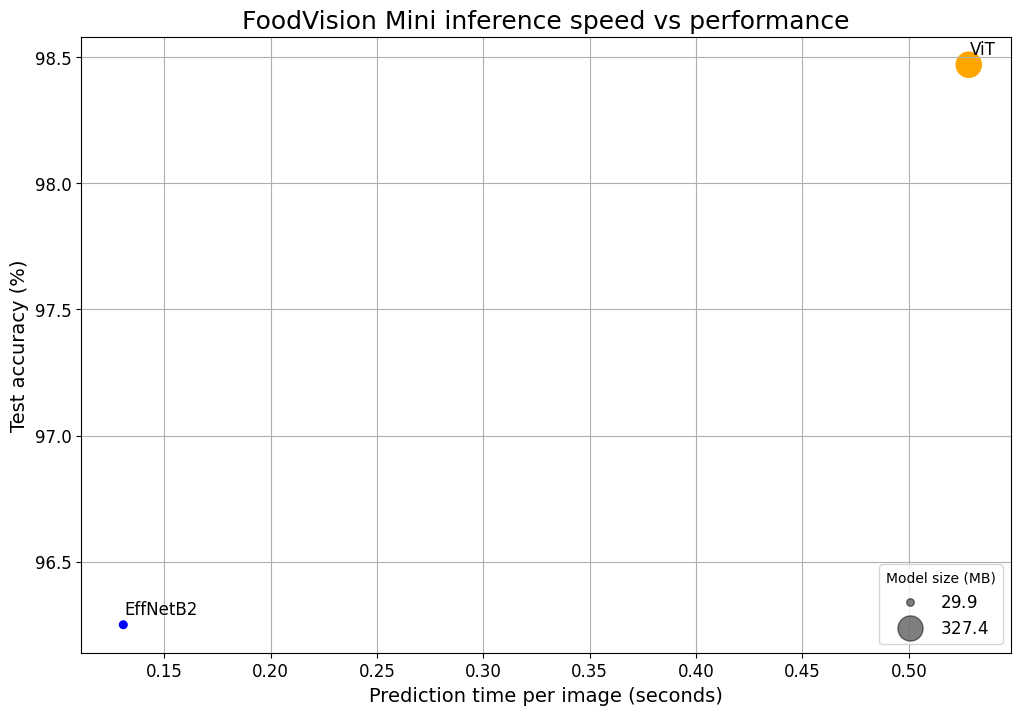

In [ ]:
# 1. Create a plot from model comparison DataFrame
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (12, 8))
scatter = ax.scatter(data = df,
                     x = 'time_per_pred_cpu',
                     y = 'test_acc',
                     c = ["blue", 'orange'],
                     s = "model_size (MB)")

# 2. Add titles and labels to make our plot look good
ax.set_title('FoodVision Mini inference speed vs performance', fontsize = 18)
ax.set_xlabel('Prediction time per image (seconds)', fontsize = 14)
ax.set_ylabel('Test accuracy (%)', fontsize = 14)
ax.tick_params(axis = "both", labelsize = 12)
ax.grid(True)

# 3. Annotate the samples on the scatter plot so we know what's going on
for index, row in df.iterrows():
  ax.annotate(text = row['model'],
              xy = (row["time_per_pred_cpu"]+ 0.0006, row["test_acc"]+0.04),
              size = 12)

# 4. Create a legend based on the model sizes (model_size (MB))
handles, labels = scatter.legend_elements(prop = 'sizes', alpha = 0.5)
model_size_lenged = ax.legend(handles, labels, loc = 'lower right', title = "Model size (MB)", fontsize = 12)

# 5. Save the figure
plt.savefig("09-foodvision-mini-inference-speed-vs-performance.png")

## 7. Bringing FoodVision mini to life by creating a Gradio demo

We've chosen to deploy EffNetB2 as it fulfils the criteria best.

What is Gradio?

> Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere! https://www.gradio.app/

In [20]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.9/315.9 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 11.4 MB/s 

### 7.1 Gradio Overview

Gradio helps you create machine learning demos.

Why create a demo?

So other people can try our models and we can test them in the real-world.

Deployment is as important as training in machine learning models.

The overall premise of the Gradio is to map: ```inputs -> ML model -> outputs```

### 7.2 Creating a function to map our inputs and outputs

In [21]:
# Put our model on the CPU
effnetb2 = effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

Let's create a function called `predict()` to go from :

```
images of food -> ML model (EffNetB2) -> outputs (food class label and prediction time)
```

In [22]:
from typing import Tuple, Dict
from timeit import default_timer as timer

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # Add batch dimension on 0th index

  # Put model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probabilities
    pred_probs = torch.softmax(effnetb2(img), dim = 1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]:float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

In [23]:
import random
from PIL import Image

# Get a list of all file paths
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
test_data_paths

# Randomly select a test image path
random_image_path =  random.sample(test_data_paths, k = 1)[0]
random_image_path

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img = image)
print(pred_dict)
print(pred_time)

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/pizza/771336.jpg

{'pizza': 0.8648099303245544, 'steak': 0.03620215505361557, 'sushi': 0.09898789972066879}
0.2239


### 7.3 Creating a list of example of images

The examples of Gradio can be created with the `examples` parameter.


In [24]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k = 3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/sushi/128616.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/2997525.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/550687.jpg']]

### 7.4 Building a Gradio Interface

Let's use `gr.Interface()` to go from:

```
input: image -> transform -> predict -> output -> pred, probs, time
```

In [25]:
import gradio as gr

# Create title, description and article
title = "FoodVision Mini 🍕🥩🍣"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html) computer vision model to classify images a spizza, steak or sushi"
article = "Created at [09. PyTorch model deployment](https://www.learnpytorch.io/09_pytorch_model_deployment)"

# Create the Gradio demo
demo = gr.Interface(fn = predict, # Maps inputs to outputs
                    inputs=gr.Image(type = 'pil'),
                    outputs = [gr.Label(num_top_classes = 3, label = "Predictions"),
                               gr.Number(label = "Prediction time (s)")],
                    examples = example_list,
                    title = title,
                    description = description,
                    article = article)

# Launch the demo
demo.launch(debug = False, # Print errors locally?
            share = True) # generate a publically shareable URL

# This link will expire in 72 hours Running on public URL: https://69c5a20dace6796655.gradio.live


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://ce8f26895398a8a59a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## 8. Turning our FoodVision Mini Gradio Demo into a deployable app

Our Gradio demo from Google Colab is are fantastic but they expire within 72 hours.

To fix this, we'ew going to prepare our app files so we can host them on HuggingFace spaces.

### 8.1 What is Hugging Face Spaces?

> Hugging Face Spaces offer a simple way to host ML demo apps directly on your profile or your organization's profile. This allows you to create your ML portfolio, showcase your projects at conferences or to stakeholders, and work collaboratively with other people in the ML ecosystem.

If GitHub is a place to show your coding ability, Hugging face Spaces is a place to show your machine learning ability (through sharing ML demos that you've built).

### 8.2 Deployed Gradio app structure

Let's start to put all of our app files into a single directory:  

```
Colab -> folder with all Gradio files -> upload app files to Hugging Face Spaces -> deploy
```

By the end or file structure will look like this:
```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```
Why use this structure?

Because it's one of the simplest we could start with.

You can see this in action:
* Deployed App:  https://d0c629a3e7e082bdfe.gradio.live


### 8.3 Creating a `demos` folder to store our FoodVision app files


In [26]:
import shutil # Directory and file operations using python
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might exist and create a new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents = True,
                                  exist_ok = True)
else:
  foodvision_mini_demo_path.mkdir(parents = True,
                                  exist_ok = True)

! ls foodvision_mini_demo_path

ls: cannot access 'foodvision_mini_demo_path': No such file or directory


### 8.4 Creating a folder of example images to use with our FoodVision mini demo

What we want:
* 3 images in an `examples/` directory
* Images should be from the test set

In [27]:
import shutil
from pathlib import Path

# Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents = True,
                                    exist_ok = True)

# Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# Copy the three images to the examples directory
for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src = example, # Copy 2 preserves metadata as well related to the file
               dst = destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


Let's now verify that we can get a list of list from our examples directory.

In [28]:
import os

# Get example filepaths from list of lists
example_list = [["examples" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples592799.jpg'], ['examples3622237.jpg'], ['examples2582289.jpg']]

### 8.5 Moving our trained EffNetB2 model to our FoodVIsion mini demo directory

In [29]:
import shutil
# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path,
                dst=effnetb2_foodvision_mini_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


### 8.6 Turning off EffNetB2 model into a Python script (`model.py`)

We have a saved `.pth` model `state_dict` and want to load it into a model instance.

Let's move our `create_effnetb2_model()` function to a script we can reuse it.


In [30]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes :int =3,
                          seed : int = 42):
  """ Create an return a pretraiend model weights and transforms """
  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model

  # 1. Setup pretrained model weights
  model_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

  # 2. Get effnetb2 transforms
  effnetb2_transforms = model_weights.transforms()

  # 3. Create model instance
  model = torchvision.models.efficientnet_b2(weights = model_weights)

  # 4. Freeze all the layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change the classifier head
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features = 1408,
                out_features = num_classes))

  return model, effnetb2_transforms

Writing demos/foodvision_mini/model.py


In [31]:
from demos.foodvision_mini import model

effnetb2_model, effnetb2_transform_import = model.create_effnetb2_model()
effnetb2_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 8.7 Turning our FoodVision Mini Gradio app into a Python script

The `app.py` file will have 4 major parts:
1. Imports and class names setup
2. Model and transforms preparation
3. Predict function (`predict()` from above)
4. Gradio app- our Gradio interface + launch command.


In [32]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


### 8.8 Creating a requirements file for FoodVision Mini (`requirements.txt`)

The requirements file will tell our Hugging Face space what software dependencies our app requires.

The three main ones are:
* `torch`
* `torchvision`
* `gradio`

In [33]:
%%writefile demos/foodvision_mini/requirements.txt
torch == 2.2.1+cu121
torchvision == 0.17.1+cu121
gradio == 4.31.4

Writing demos/foodvision_mini/requirements.txt


## 9. Deploying our FoodVision Mini app on Higging Face Spaces

### 9.1 Downloading our FoodVision Mini app files

We want to download our `foodvision_mini` demo app so we can upload it to Hugging Face Spaces.

There are two main options for uploading to a Hugging Face Space (also called a Hugging Face Repository, similar to a git repository):

* Uploading via the Hugging Face Web interface (easiest).
* Uploading via the command line or terminal.
> Bonus: You can also use the huggingface_hub library to interact with Hugging Face, this would be a good extension to the above two options.

In [34]:
!ls -l demos/foodvision_mini

total 30604
-rw-r--r-- 1 root root 31314554 May 18 13:37 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
-rw-r--r-- 1 root root     2888 May 18 13:38 app.py
drwxr-xr-x 2 root root     4096 May 18 13:38 examples
-rw-r--r-- 1 root root      943 May 18 13:38 model.py
drwxr-xr-x 2 root root     4096 May 18 13:38 __pycache__
-rw-r--r-- 1 root root       66 May 18 13:38 requirements.txt


In [35]:
# Change into the foodvision_mini directory and then zip it from inside
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*pyc" "*ipynb" "*__pycache__*" "*ipynb_checkpoint*"

  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 57%)
  adding: examples/ (stored 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: model.py (deflated 52%)
  adding: requirements.txt (deflated 18%)


In [36]:
# Download
try:
  from google.colab import files
  files.download("demos/foodvision_mini.zip")
except:
  print("[INFO] Not running on Google Colab, can't use google.colab.files.download()")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.2 Running our Gradio demo app locally

Running the app locally.

### 9.3 Uploading our FoddVision Mini Gradio demo to Hugging Face spaces
